This script calculates an airfoil and outputs it to a format to be read by gmsh works for gmsh 4.7.1

In [1]:
#import common modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import airfoil as ar
import stl
import cv2

from mpl_toolkits import mplot3d
from pathlib import Path

(-0.04967955049796729,
 1.0519605606779805,
 -0.06607890091836452,
 0.06591889970004558)

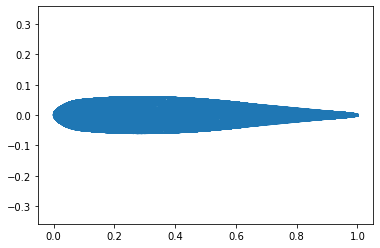

In [2]:
# STL location
location_stl = Path(r'C:\Users\MC\Documents\gitDocuments\IkaFlow\fishClosed_1m.stl')

# Load the STL files and add the vectors to the plot
stl_mesh =stl.mesh.Mesh.from_file(location_stl)

v0_mesh = stl_mesh.v0
v1_mesh = stl_mesh.v1
v2_mesh = stl_mesh.v2

fig1, ax1 = plt.subplots()
ax1.plot(v0_mesh[:,0], v0_mesh[:,1])
#ax1.plot(v1_mesh[:,0], v1_mesh[:,1])
#ax1.plot(v2_mesh[:,0], v2_mesh[:,1])
ax1.axis('equal')

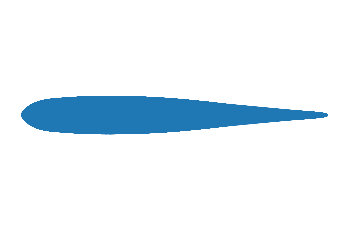

In [3]:
img_location = Path('./modifiedFoil.png')
fig2, ax2 = plt.subplots()
ax2.plot(stl_mesh.x.flatten(), stl_mesh.y.flatten())
ax2.axis('equal')
ax2.axis('off')
fig2.savefig(img_location, facecolor='w')

In [4]:
img2 = cv2.imread(img_location.as_posix(), cv2.IMREAD_COLOR)
img = cv2.imread(img_location.as_posix(), cv2.IMREAD_GRAYSCALE)
# Converting image to a binary image
# ( black and white only image).
_, threshold = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY)
  
# Detecting contours in image.
cnts, _= cv2.findContours(threshold, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)

(-0.05, 1.05, -0.066, 0.066)

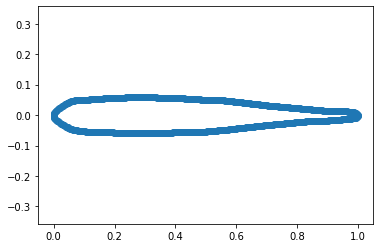

In [5]:
# create a blank image
mask = np.zeros(img.shape, dtype=np.uint8)
# find the pixel points
cv2.drawContours(mask, cnts, 1, 255, 1)
# Get the contour points
pixelPoints = np.transpose(np.nonzero(mask))
hullX = pixelPoints[:,1]
hullY = pixelPoints[:,0]

# perform some shifting to get the original object
hullX = hullX - np.min(hullX)
hullY = hullY - (np.max(hullY) + np.min(hullY))/2

length_ = 1.0
height_ = 0.06

hullX = hullX * (length_ / np.max(hullX))
hullY = hullY * (height_ / np.max(hullY))

sort_ind = np.argsort(hullX, axis=0)
hullX = hullX[sort_ind]
hullY = hullY[sort_ind]

fig3, ax3 = plt.subplots()
ax3.plot(hullX, hullY, 'o')
ax3.axis('equal')

In [6]:
# now we sample and condition the data so we can put it in gmsh
coord_points = 50

yu_indices = np.where(hullY >= 0)[0]

yu_fit = np.polyfit(hullX[yu_indices], hullY[yu_indices], 8)
yu_poly = np.poly1d(yu_fit)

beta = np.linspace(0, np.pi, coord_points)
xu = (0.5*(1-np.cos(beta)))
xl = xu
yu = yu_poly(xu)
yl = -yu_poly(xu)


In [7]:
# Create array for writing
point = np.zeros((2*coord_points-2,3));
ind = 0;

point[0:coord_points, 0] = xu
point[0:coord_points, 1] = yu
point[0:coord_points, 2] = 0.0

point[coord_points:, 0] = np.flipud(xl[1:-1])
point[coord_points:, 1] = np.flipud(yl[1:-1])
point[coord_points:, 2] = 0.0

num_points = point.shape[0];
airfoil_point_numbers = np.arange(1, num_points, 1)
num_lines = num_points;

# perform some conditioning on the 0 coordinate and max length coordinate 
# so that the b-spline connects better
point[np.where(point[:,0] == length_), 1] = 0.0
point[np.where(point[:,0] == 0.0), 1] = 0.0

We can make things easier by defining a characteristic length for the mesh and a fluid domain based on the geometry

In this case:

all variables are a factor of total length e.g. 40 is 40 * length of airfoil

Lx_plus = length behind the airfoil

Lx_minus = length in front of airfoil

Ly = length top and bottom of airfoil

No we should calculate the y+ value and all our boundary layer values

Credit to https://www.fluidmechanics101.com/pdf/calculators.pdf

For the calculation processes


In [8]:
# Define our setup variables
U = 1.0                                 # Freestream Velocity                                 # Length            
density = 1025                          # fluid density
kinVisc = 1e-8                       # kinematic viscosity of fluid
dynamicVisc = density * kinVisc         # dynamic viscosity of fluid
yPlus = 5.0                             # desired Y+
growth_ratio = 1.1                      # growth ratio
N = 30                                  # number of inflation layers

# calculate the Reynolds Number
Re = U * length_ / kinVisc

# calculate the skin friction coefficient
Cf = (2*np.log10(Re) - 0.65)**(-2.3)

# calculate the shear wall stress
tw = 0.5 * density * U**2 * Cf

# calculate the friction velocity
ut = np.sqrt(tw / density)

# calculate yp where yp is the distance to the centroid of the first cell
# based on desired y+. yH is the first cell height which is 2 times the centroid
yp =  (yPlus * dynamicVisc) / (ut * density)

yH = 2 * yp

# Estimate the boundary layer thickness using the Blasius solution
# laminar and turbulent are given here
if ( Re < 4e5):
    delta = 4.91 * length_ / np.sqrt(Re)
else:
    delta = 0.38 * length_ / Re**(1/5)

# calculate the total thickness of the inflation layers yT
# specify the growth ratio
yT = yH * ((1 - growth_ratio**N)/(1 - growth_ratio))

#f = lambda r: (1.14e-8 * ((1 - r**20)/(1 - r)) - 0.00288)

#growth_ratio_calc = optimize.fsolve(f, 1.1)
# Give the final layer thickness
yFinal = yH * growth_ratio**(N - 1)

print(yH, growth_ratio, yFinal)

3.2699388761451724e-06 1.1 5.187134440411597e-05


We can make things easier by defining a characteristic length for the mesh and a fluid domain based on the geometry

In this case:

all variables are a factor of total length e.g. 40 is 40 * length of airfoil

Lx_plus = length behind the airfoil

Lx_minus = length in front of airfoil

Ly = length top and bottom of airfoil


In [9]:
airfoil_cl = 0.0025
wall_cl = 0.1
Lx_plus = 1.5
Lx_minus = -0.5
Ly_plus = 0.5
Ly_minus = -0.5 

hfar = 0.0001
hwall_n = 0.00005
thickness = 0.01  # thickness of boundary layer

In [10]:
#Write data to the .geo file
with open('modifiedAirfoil.geo', 'w') as df:
    # first we write the variables for easy changing locally later
    df.write('airfoil_cl = %f;\n' % (airfoil_cl))
    df.write('wall_cl = %f;\n' % (wall_cl))
    df.write('Lx_plus = %f;\n' % (Lx_plus * length_))
    df.write('Lx_minus = %f;\n' % (Lx_minus * length_))
    df.write('Ly_plus = %f;\n' % (Ly_plus * length_))
    df.write('Ly_minus = %f;\n' % (Ly_minus * length_))
    df.write('\n')

    for i in np.arange(0, num_points, 1):
        df.write('Point(%i) = {%f, %f, %f, airfoil_cl};\n' % (i+1, point[i,0], point[i,1],
                                                    point[i,2]))
    df.write('\n')
    
    # define the domain point numbers and domain line numbers
    domain_points = np.arange(num_points + 1, num_points + 5, 1)
    domain_lines = np.arange(num_lines + 1, num_lines + 5, 1)
    line_loops = np.array([101, 102])
    plane_surface = np.array([201])
    
    # write the fluid domain points
    df.write('// Define bounding box corners for fluid domain \n')        
    df.write('Point(%i) = {Lx_minus, Ly_minus, 0.0000, wall_cl};\n' % (domain_points[0]))
    df.write('Point(%i) = {Lx_minus, Ly_plus, 0.0000, wall_cl};\n' % (domain_points[1]))
    df.write('Point(%i) = {Lx_plus, Ly_plus, 0.0000, wall_cl};\n' % (domain_points[2]))
    df.write('Point(%i) = {Lx_plus, Ly_minus, 0.0000, wall_cl};\n' % (domain_points[3]))
    df.write('\n')
    
    # write the fluid domain lines
    df.write('// Make line loops for the fluid domain\n')
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[0], domain_points[0], domain_points[1]))
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[1], domain_points[1], domain_points[2]))
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[2], domain_points[2], domain_points[3]))
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[3], domain_points[3], domain_points[0]))
    df.write('\n')
    
    # combine the loops into a surface
    df.write('// Combine the fluid domain lines\n')
    df.write('Line Loop(' + str(line_loops[0]) + ') = {' + np.array2string(domain_lines, separator = ', ').strip('[]') + '}; \n')
    
    df.write('\n')
    df.write('// combine foil points into a bspline \n')
    df.write('BSpline(5) = {'  + str(airfoil_point_numbers[0]) + ':' + str(coord_points) + '}; \n')
    df.write('BSpline(6) = {' + str(coord_points) + ':' + str(num_points) + ',' +  str(airfoil_point_numbers[0]) + '}; \n')
    df.write('Line Loop(' + str(line_loops[1]) + ') = {5, 6}; \n') 
    df.write('\n')

    df.write('Plane Surface(' + str(plane_surface[0]) + ') = {101, 102}; \n')
    
    df.write('\n')
    # extrude the surface so we can name the boundaries
    df.write('Extrude {0, 0, 1} {\n Surface{' + str(plane_surface[0]) + '};\n Layers{1};\n Recombine;\n}')
    df.write('\n')

    # define the physical surface patches
    df.write('// Define the physical surfaces -> values are obtained via the GUI \n')
    df.write('Physical Surface("overset") = {212, 216, 220, 224}; \n')
    df.write('Physical Surface("symFront") = {233}; \n')
    df.write('Physical Surface("symBack") = {201}; \n')
    df.write('Physical Surface("wingTop") = {232}; \n')
    df.write('Physical Surface("wingBottom") = {228}; \n')
    df.write('\n')

    # define the internal volume
    df.write('// Define the internal volume - usually 1 but obtained from GUI \n')
    df.write('Physical Volume("internal") = {1};\n')
    df.write('\n')

    # define the boundary layer addition
    df.write('//Define the boundary layer \n')
    df.write('Field[1] = BoundaryLayer; \n')
    df.write('Field[1].EdgesList = {5, 6}; \n')
    df.write('Field[1].NodesList = {1, 1021, 1022, ' + str(airfoil_point_numbers[-1]) + '}; \n')
    df.write('Field[1].hfar = ' + str(hfar) + '; \n')
    df.write('Field[1].hwall_n = ' + str(hwall_n) + '; \n')
    df.write('Field[1].thickness = ' + str(thickness) + '; \n')
    df.write('Field[1].ratio = ' + str(growth_ratio) + '; \n')
    df.write('Field[1].AnisoMax = 10; \n')
    df.write('Field[1].Quads = 1; \n')
    df.write('Field[1].IntersectMetrics = 0; \n')
    df.write('BoundaryLayer Field = 1; \n')